### Imports

In [1]:
from ST3DNet import *
import pickle
from utils import *
import os
import math
from keras.utils import plot_model
from keras.optimizers import Adam
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from keras.callbacks import EarlyStopping, ModelCheckpoint

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2024-04-01 22:11:26.644085: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-01 22:11:29.478252: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-01 22:11:29.481714: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-01 22:11:33.138731: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Training Info

In [3]:
nb_epoch = 1500  # number of epoch at training stage
nb_epoch_cont = 20  # number of epoch at training (cont) stage
batch_size = 32  # batch size
T = 3  # number of time intervals in one day
lr = 0.00002  # learning rate
len_closeness = 6  # length of closeness dependent sequence
len_period = 0  # length of period dependent sequence
len_trend = 4  # length of trend dependent sequence
nb_residual_unit = 4   # number of residual units
nb_flow = 2  # there are two types of flows: new-flow and end-flow
days_test = 10  # divide data into two subsets: Train & Test, of which the test set is the last 10 days
len_test = T * days_test
map_height, map_width = 24,16  # grid size
nb_area = 81
m_factor = math.sqrt(1. * map_height * map_width / nb_area)


### Load Data

In [4]:
filename = os.path.join("data", 'crime_c%d_p%d_t%d_noext'%(len_closeness, len_period, len_trend))
f = open(filename, 'rb')
X_train = pickle.load(f)
Y_train = pickle.load(f)
X_test = pickle.load(f)
Y_test = pickle.load(f)
mmn = pickle.load(f)
external_dim = pickle.load(f)
timestamp_train = pickle.load(f)
timestamp_test = pickle.load(f)


Y_train = mmn.inverse_transform(Y_train)  # X is MaxMinNormalized, Y is real value
Y_test = mmn.inverse_transform(Y_test)

### Model Setup

In [7]:
c_conf = (len_closeness, nb_flow, map_height,
              map_width) if len_closeness > 0 else None
t_conf = (len_trend, nb_flow, map_height,
          map_width) if len_trend > 0 else None
model = ST3DNet(c_conf=c_conf, t_conf=t_conf, external_dim=external_dim, nb_residual_unit=nb_residual_unit)

adam = Adam(lr=lr)
model.compile(loss='mse', optimizer=adam, metrics=[rmse, mae])
model.summary()
plot_model(model,show_shapes=True)

2024-04-01 19:20:13.569814: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


external_dim: None
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 6, 16, 8  0           []                               
                                )]                                                                
                                                                                                  
 conv3d (Conv3D)                (None, 64, 6, 16, 8  6976        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 64, 6, 16, 8  0           ['conv3d[0][0]']                 
                                )                                          

/home/matheus/miniconda3/envs/st3dnet/lib/python3.9/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Loading Model

In [8]:
hyperparams_name = 'c{}.p{}.t{}.resunit{}.lr{}'.format(
        len_closeness, len_period, len_trend, nb_residual_unit, lr)
fname_param = 'crime_{}.best.h5'.format(hyperparams_name)

model.load_weights(fname_param)

### Evaluating Model

In [9]:
score = model.evaluate(X_train, Y_train, batch_size=Y_train.shape[0] // 48, verbose=1)

print('Train score:\n %.6f  RMSE (real): %.6f MAE (real): %.6f RMSE: %.6f MAE: %.6f' %
       (score[0], score[1] * m_factor, score[2] * m_factor,score[1], score[2]))

score = model.evaluate(X_test, Y_test, batch_size=Y_test.shape[0], verbose=1)

print('Test score:\n %.6f  RMSE (real): %.6f MAE (real): %.6f RMSE: %.6f MAE: %.6f' %
       (score[0], score[1] * m_factor, score[2] * m_factor,score[1], score[2]))


2024-04-01 19:20:34.041411: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'model/activation_6/Relu' exist for missing node 'model/add/add'.
2024-04-01 19:20:34.062555: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'model/activation_6/Relu' exist for missing node 'model/add/add'.


49/49 [==============================] - 57s 1s/step - loss: 1.1764 - rmse: 1.0849 - mae: 0.5510
Train score:
 1.176355  RMSE (real): 1.363854 MAE (real): 0.692650 RMSE: 1.084939 MAE: 0.551000
1/1 [==============================] - 0s 397ms/step - loss: 1.1837 - rmse: 1.0880 - mae: 0.5491
Test score:
 1.183739  RMSE (real): 1.367699 MAE (real): 0.690268 RMSE: 1.087998 MAE: 0.549105


In [10]:
result=model.predict(X_test)

1/8 [==>...........................] - ETA: 1s

2024-04-01 19:22:29.287781: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'model/activation_6/Relu' exist for missing node 'model/add/add'.
2024-04-01 19:22:29.303867: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'model/activation_6/Relu' exist for missing node 'model/add/add'.


8/8 [==============================] - 1s 73ms/step


In [11]:
print(len(X_test))

2


In [12]:
print("Closeness component: ", X_test[0].shape)
print("Trend Component: ", X_test[1].shape)

Closeness component:  (240, 2, 6, 16, 8)
Trend Component:  (240, 2, 4, 16, 8)


In [13]:
print("Closeness component: ", X_train[0].shape)
print("Trend Component: ", X_train[1].shape)

Closeness component:  (41976, 2, 6, 16, 8)
Trend Component:  (41976, 2, 4, 16, 8)


In [14]:
print(timestamp_train[0])
print(timestamp_train[-1])

b'2018113001'
b'2023100524'


In [19]:
for i in range(0,24):
    print(timestamp_train[i])

b'2018113001'
b'2018113002'
b'2018113003'
b'2018113004'
b'2018113005'
b'2018113006'
b'2018113007'
b'2018113008'
b'2018113009'
b'2018113010'
b'2018113011'
b'2018113012'
b'2018113013'
b'2018113014'
b'2018113015'
b'2018113016'
b'2018113017'
b'2018113018'
b'2018113019'
b'2018113020'
b'2018113021'
b'2018113022'
b'2018113023'
b'2018113024'


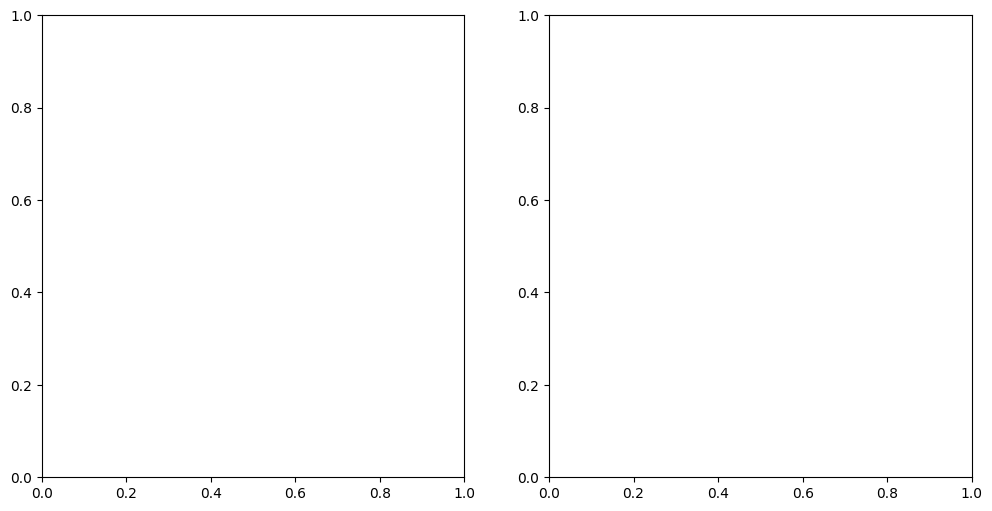

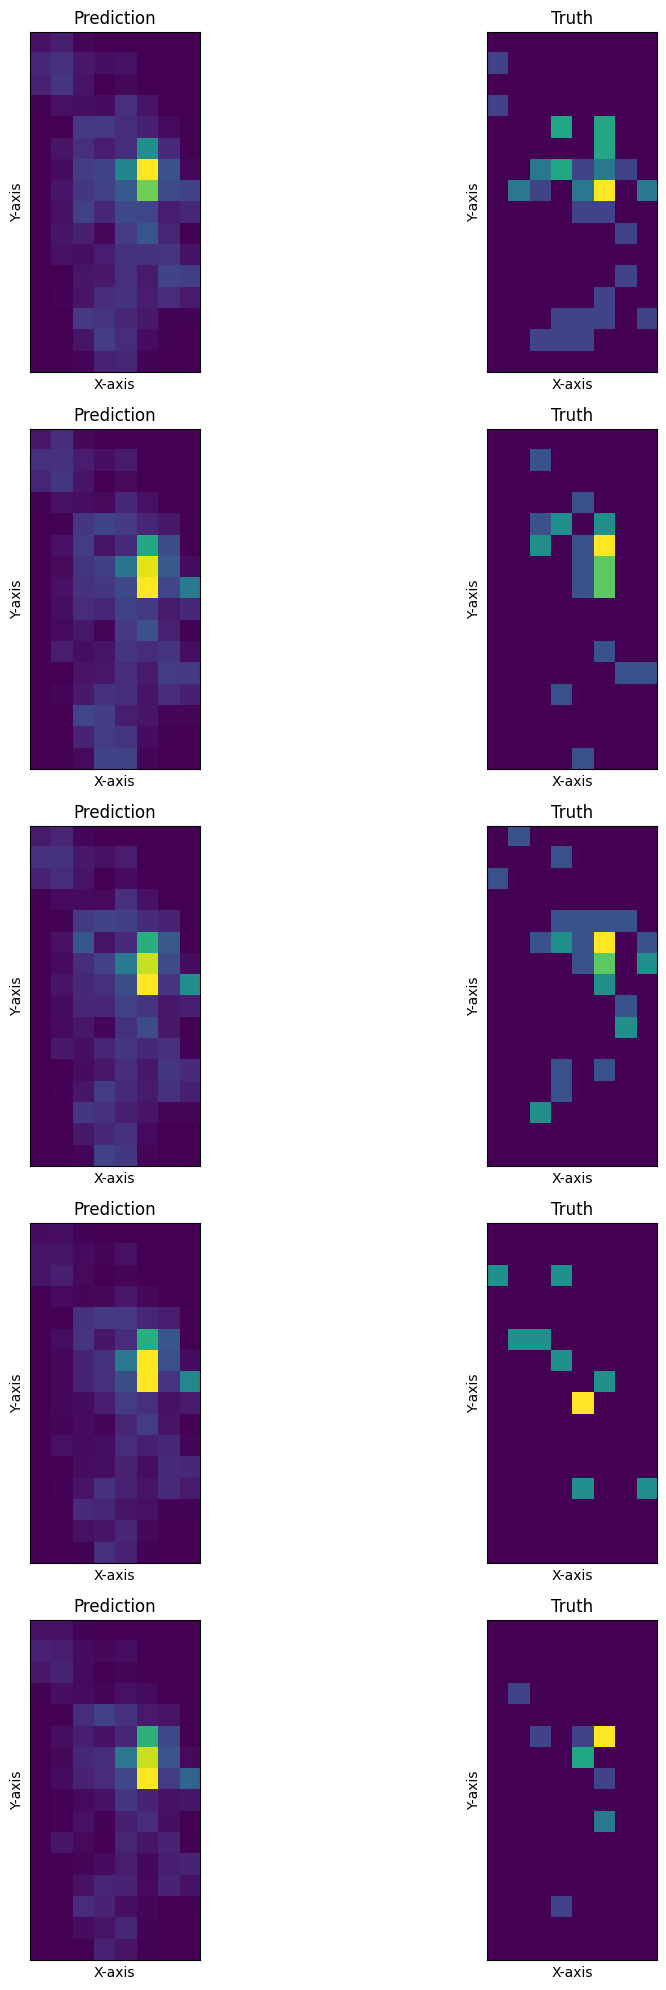

In [18]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
i=0
# Plot the first heatmap
num_plots = 5
fig, axes = plt.subplots(num_plots, 2, figsize=(12, num_plots*4))

for i in range(num_plots):
    # Plot the first heatmap (Prediction)
    prediction = result[i][0] + result[i][1]
    axes[i, 0].imshow(prediction, cmap='viridis', interpolation='nearest')
    axes[i, 0].set_title('Prediction')
    axes[i, 0].set_xlabel('X-axis')
    axes[i, 0].set_ylabel('Y-axis')
    axes[i, 0].set_xticks([])  # Hide x-axis ticks
    axes[i, 0].set_yticks([])  # Hide y-axis ticks

    # Plot the second heatmap (Truth)
    truth = Y_test[i][0] + Y_test[i][1]
    axes[i, 1].imshow(truth, cmap='viridis', interpolation='nearest')
    axes[i, 1].set_title('Truth')
    axes[i, 1].set_xlabel('X-axis')
    axes[i, 1].set_ylabel('Y-axis')
    axes[i, 1].set_xticks([])  # Hide x-axis ticks
    axes[i, 1].set_yticks([])  # Hide y-axis ticks

# Ajustar layout para prevenir corte dos rótulos do eixo
plt.tight_layout()

# Exibir os gráficos
plt.show()